In [1]:
import os
import math
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import torch
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

In [2]:
plt.style.use([hep.style.ROOT, hep.style.firamath])
plt.rcParams.update({'lines.markersize': 6})
plt.rcParams.update({'errorbar.capsize': 8})
plt.rcParams.update({'lines.linewidth': 2})

In [3]:
from src.models import TranAD, iTransformer

In [4]:
modes = ['local (incl. OR)', 'local (maj. voting)', 'global']

## read results

In [ ]:
datasets = ['creditcard_normal', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMAP_new', 'SMD', 'SWaT_1D', 'UCR', 'WADI'] # SWaT'
modeltype = 'iTransformer'
reco = False

In [6]:
all_results = {dataset: {} for dataset in datasets}

for dataset in datasets:
    config = {}

    print(f'Loading {dataset}')
    if reco:
        paths = glob.glob(f'{modeltype}_paramsearch_reco_lxplus/{modeltype}_{dataset}/*' )
    else:
        paths = glob.glob(f'{modeltype}_paramsearch_fc_lxplus/{modeltype}_{dataset}/*' )
    paths = [p for p in paths if not '.txt' in p]
    paths = sorted(paths)
    print(len(paths)) 
    # print(paths)

    for path in paths:
        key = path.split('/')[2]
        path = glob.glob(f'{path}/rep_*/results/')  # will give all 5 repetitions
        path = sorted(path)
        # print(len(path))

        tmp = pd.DataFrame()
        for i, rep_path in enumerate(path):
            res_path = os.path.join(rep_path, 'res.csv')
            # print(res_path)
            if not os.path.exists(res_path):
                print(f'Skipping {key} rep {i+1}')
                continue
            res = pd.read_csv(res_path).iloc[-3:]
            tmp = pd.concat((tmp, res))
        
        tmp.rename(columns={'Unnamed: 0': 'mode'}, inplace=True)
        mean_values = tmp.groupby('mode').mean()
        std_values = tmp.groupby('mode').std()
        median_values = tmp.groupby('mode').median()
        mean_values = mean_values.reindex(['local_all', 'local_all_maj', 'global'])
        std_values = std_values.reindex(['local_all', 'local_all_maj', 'global'])
        median_values = median_values.reindex(['local_all', 'local_all_maj', 'global'])

        window_value = key.split('_')[0].replace('window', '')
        steps_value = key.split('_')[1].replace('steps', '')
        dmodel_value = key.split('_')[2].replace('dmodel', '')
        feats_value = key.split('_')[3].replace('feats', '')
        eps_value = key.split('_')[4].replace('eps', '')
        config[key] = {'window': window_value, 'steps': steps_value, 'dmodel': dmodel_value, 'feats': feats_value, 'eps': eps_value}
        all_results[dataset][key] = {'mean': mean_values, 'std': std_values, 'median': median_values, 'window': window_value, 'steps': steps_value, 'dmodel': dmodel_value,}

    config = pd.DataFrame(config).T
    if reco:
        config.to_csv(f'studies_paramsearch_reco/configs/{dataset}_config.csv')
    else:
        config.to_csv(f'studies_paramsearch_fc/configs/{dataset}_config.csv')
        
print(all_results['creditcard_normal']['window10_steps1_dmodel10_feats-1_eps10']['mean'])


Loading creditcard
0
Loading creditcard_normal
12
Loading GECCO
0
Loading GECCO_normal
12
Loading IEEECIS_new2.2
12
Loading MSL_new
12


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
best_config = []

for dataset, results in all_results.items():
    if results == {}:
        continue
    print(dataset)
    mcc_scores = []
    for key, metrics in results.items():
        mcc_scores.append({
            'dataset': dataset,
            'model': key,
            'local_all': metrics['mean'].loc['local_all', 'MCC'],
            'local_all_maj': metrics['mean'].loc['local_all_maj', 'MCC'],
            'global': metrics['mean'].loc['global', 'MCC'],
            'max_MCC': metrics['mean']['MCC'].max(),
            'max_MCC_mode': metrics['mean']['MCC'].idxmax(),
            'local_all_std': rf"{metrics['mean'].loc['local_all', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['local_all', 'MCC'].round(3)}",
            'local_all_maj_std': rf"{metrics['mean'].loc['local_all_maj', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['local_all_maj', 'MCC'].round(3)}",
            'global_std': rf"{metrics['mean'].loc['global', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['global', 'MCC'].round(3)}",
            'window': metrics['window'],
            'steps': metrics['steps'],
            'dmodel': metrics['dmodel'],
        })
    mcc_df = pd.DataFrame(mcc_scores)
    # print(mcc_df)
    if reco:
        mcc_df.to_csv(f'studies_paramsearch_reco/data/{dataset}_mcc.csv')
    else:
        mcc_df.to_csv(f'studies_paramsearch_fc/data/{dataset}_mcc.csv')

    best_idx = mcc_df['max_MCC'].idxmax()
    # print('idx', best_idx)
    best_config.append({
        'dataset': dataset,
        'model': mcc_df['model'][best_idx],
        'max_MCC': mcc_df['max_MCC'].max().round(3),
        'max_MCC_mode': mcc_df['max_MCC_mode'][best_idx],
        'window': mcc_df['window'][best_idx],
        'steps': mcc_df['steps'][best_idx],
        'dmodel': mcc_df['dmodel'][best_idx],
    })
    
best_config = pd.DataFrame(best_config)
print(best_config)
if reco:
    best_config.to_csv(f'studies_paramsearch_reco/configs/best_config.csv')
else:
    best_config.to_csv(f'studies_paramsearch_fc/configs/best_config.csv')

In [7]:
def plot_scores_mean_std_err2(results, modes, dataset, models, metric='MCC', name=None, labels=None):
    if labels is None:
        labels = [f"W: {results[dataset][model]['window']}, S: {results[dataset][model]['steps']}, M: {results[dataset][model]['dmodel']}" for model in models]

    if 'MSE' in results[dataset].keys():
        fig = plt.figure(figsize=(20, 7))
    else:
        fig = plt.figure(figsize=(25, 5))
    colors = plt.cm.plasma(np.linspace(0, 1, len(models)+1))
    markers = ['o', 's', 'D']  # Different markers for different modes
    plt.rcParams.update({'lines.markersize': 8})

    width_modes = 0.015  # the width of the bars
    width_models = 0.025
    x = np.arange(1)  # the label locations

    for j, model in enumerate(models):
        for i, mode in enumerate(modes):
            # print(f'{model} {mode} {dataset}')
            scores = {'mean': np.empty(0), 'std': np.empty(0)}
            for val in ['mean', 'std']:
                if model in results[dataset].keys():
                    scores[val] = np.append(scores[val], results[dataset][model][val][metric].iloc[i])
                else:
                    scores[val] = np.append(scores[val], 0)
                # print(f'{val}: {scores[val]}')

            x_positions = x + j * len(modes) * width_models + i * width_modes  # add different offset for each model and mode
            plt.errorbar(x_positions, scores['mean'], yerr=scores['std'], fmt=markers[i], label=f'{labels[j]} ({mode})', color=colors[j])
    x_end = x_positions[-1]
    plt.xticks(ticks=[x_end / 2], labels=[dataset])
    plt.grid('gray', axis='y')
    if metric == 'MCC':
        plt.ylim(-0.2, 1.05)
    else:
        plt.ylim(top=1.0)
    if metric == 'ROC/AUC':
        plt.ylabel('ROC AUC')
    elif metric == 'f1':
        plt.ylabel('F1')
    else:
        plt.ylabel(metric)
    
    if 'MSE' in results[dataset].keys():
        plt.title(f"iTransformer config: W: {results[dataset]['MSE']['window']}, S: {results[dataset]['MSE']['steps']}, M: {results[dataset]['MSE']['dmodel']}")

    # Create legend handles for colors
    color_handles = [
        mpatches.Patch(color=colors[i], label=labels[i]) for i, model in enumerate(models)
    ]

    # Create legend handles for marker shapes
    shape_handles = [
        mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label=modes[0]),
        mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=10, label=modes[1]),
        mlines.Line2D([], [], color='black', marker='D', linestyle='None', markersize=10, label=modes[2]),
    ]

    # Add separate legends to the plot
    if dataset in ['MSL_new', 'SMAP_new', 'SWaT', 'WADI']:  # 'SWaT_1D'
        legend2 = plt.legend(handles=shape_handles, title='Anomaly labels', bbox_to_anchor=(0.7, 0.4), loc='upper left') 
    elif dataset in ['SMD']:
        legend2 = plt.legend(handles=shape_handles, title='Anomaly labels', bbox_to_anchor=(0.7, 0.65), loc='upper left')
    else:
        legend2 = plt.legend(handles=shape_handles, title='Anomaly labels', bbox_to_anchor=(0.7, 1.0), loc='upper left')  
    plt.gca().add_artist(legend2)  # Add the first legend manually to the axes
    if 'MSE' in results[dataset].keys():
        legend1 = plt.legend(handles=color_handles, title='Loss functions', bbox_to_anchor=(1, 1.05), loc='upper left')
    else:
        legend1 = plt.legend(handles=color_handles, title='Models', bbox_to_anchor=(1, 1.05), loc='upper left')
    # plt.gca().add_artist(legend1)  # Add the first legend manually to the axes
    
    plt.tight_layout()
    if name:
        if metric == 'ROC/AUC':
            metric = 'rocauc'
        if 'MSE' in results[dataset].keys(): 
            if reco:
                plt.savefig(f'./studies_loss_reco/{dataset}_{metric}_{name}.png', facecolor='w')
            else:
                plt.savefig(f'./studies_loss_fc/{dataset}_{metric}_{name}.png', facecolor='w')
        else:
            if reco:
                plt.savefig(f'./studies_paramsearch_reco/{dataset}_{metric}_{name}.png', facecolor='w')
            else:
                plt.savefig(f'./studies_paramsearch_fc/{dataset}_{metric}_{name}.png', facecolor='w')
    plt.show()


In [ ]:
data_plot = datasets  # ['creditcard_normal', 'GECCO_normal', 'MSL_new', 'SMAP_new', 'SWaT_1D', 'UCR']

for dataset in data_plot:
    models_plot = sorted(list(all_results[dataset].keys()))
    labels = [l[:-14] for l in models_plot]
    labels = [l.replace('_', ' ') for l in labels]
    name = 'reco2'
    # name = None
    plot_scores_mean_std_err2(all_results, modes, dataset, models_plot, metric='MCC', name=name, labels=None)


## loss fct comparison

In [8]:
datasets = ['creditcard', 'creditcard_normal', 'GECCO', 'GECCO_normal', 'IEEECIS_new2.2', 'MSL_new', 'SMAP_new', 'SMD', 'SWaT', 'SWaT_1D', 'UCR', 'WADI'] # SWaT'
modeltype = 'iTransformer'
# loss_fct = ['MSE', 'Huber', 'Huber_quant', 'penalty']
reco = True

In [12]:
all_results = {dataset: {} for dataset in datasets}

for dataset in datasets:

    print(f'Loading {dataset}')
    if reco:
        paths = glob.glob(f'{modeltype}_loss_fct/{modeltype}_{dataset}/*' )
    else:
        paths = glob.glob(f'{modeltype}_loss_fct/{modeltype}_{dataset}/*' )
    paths = [p for p in paths if not '.txt' in p]
    paths = [p for p in paths if not '.log' in p]
    paths = sorted(paths)
    print(len(paths)) 
    # print(paths)

    for path in paths:
        if 'penalty' in path:
            loss_type = 'penalty'
        elif 'Huber_quant' in path:
            loss_type = 'Huber_quant'
        elif 'Huber' in path:
            loss_type = 'Huber'
        else:
            loss_type = 'MSE'
        key = path.split('/')[2]
        
        for j in range(2):
            if j == 0:
                res_path = glob.glob(f'{path}/rep_*/results/')  # will give all 5 repetitions
                res_path = sorted(res_path)
            # elif j == 1 and loss_type == 'Huber': # unnecessary for MSE
            #     res_path = glob.glob(f'{path}/testMSE/rep_*/results/') # will give all 5 repetitions with MSE for test loss
            #     res_path = sorted(res_path)
            #     loss_type = loss_type + '_testMSE'
            else:
                continue
            # print(len(res_path))
            # print(res_path)

            tmp = pd.DataFrame()
            for i, rep_path in enumerate(res_path):
                final_path = os.path.join(rep_path, 'res.csv')
                # print(final_path)
                if not os.path.exists(final_path):
                    print(f'Skipping {key} rep {i+1}')
                    continue
                res = pd.read_csv(final_path).iloc[-3:]
                tmp = pd.concat((tmp, res))
            
            tmp.rename(columns={'Unnamed: 0': 'mode'}, inplace=True)
            mean_values = tmp.groupby('mode').mean()
            std_values = tmp.groupby('mode').std()
            median_values = tmp.groupby('mode').median()
            mean_values = mean_values.reindex(['local_all', 'local_all_maj', 'global'])
            std_values = std_values.reindex(['local_all', 'local_all_maj', 'global'])
            median_values = median_values.reindex(['local_all', 'local_all_maj', 'global'])

            window_value = key.split('_')[0].replace('window', '')
            steps_value = key.split('_')[1].replace('steps', '')
            dmodel_value = key.split('_')[2].replace('dmodel', '')
            feats_value = key.split('_')[3].replace('feats', '')
            eps_value = key.split('_')[4].replace('eps', '')
            all_results[dataset][loss_type] = {'mean': mean_values, 'std': std_values, 'median': median_values, 
                                        'window': window_value, 'steps': steps_value, 'dmodel': dmodel_value,
                                        'loss_type': loss_type}

        
print(all_results['creditcard_normal'].keys())
print(all_results['creditcard_normal']['penalty']['mean'])

Loading creditcard
4
Loading creditcard_normal
4
Loading GECCO
4
Loading GECCO_normal
4
Loading IEEECIS_new2.2
4
Loading MSL_new
4
Loading SMAP_new
4
Loading SMD
4
Loading SWaT
4
Loading SWaT_1D
4
Loading UCR
4
Loading WADI
4
dict_keys(['MSE', 'Huber', 'Huber_quant', 'penalty'])
                     f1  precision    recall   TP       TN     FP     FN  \
mode                                                                       
local_all      0.002519   0.001458  0.009259  1.0  84883.4  451.6  107.0   
local_all_maj  0.000000   0.000000  0.000000  0.0  85304.8   30.2  108.0   
global         0.000000   0.000000  0.000000  0.0  85293.0   42.0  108.0   

                ROC/AUC       MCC  threshold  detection level q  Hit@100%  \
mode                                                                        
local_all      0.501984  0.001156        NaN            0.00001       NaN   
local_all_maj  0.499823 -0.000656        NaN            0.00001       NaN   
global         0.499754 -0.0007

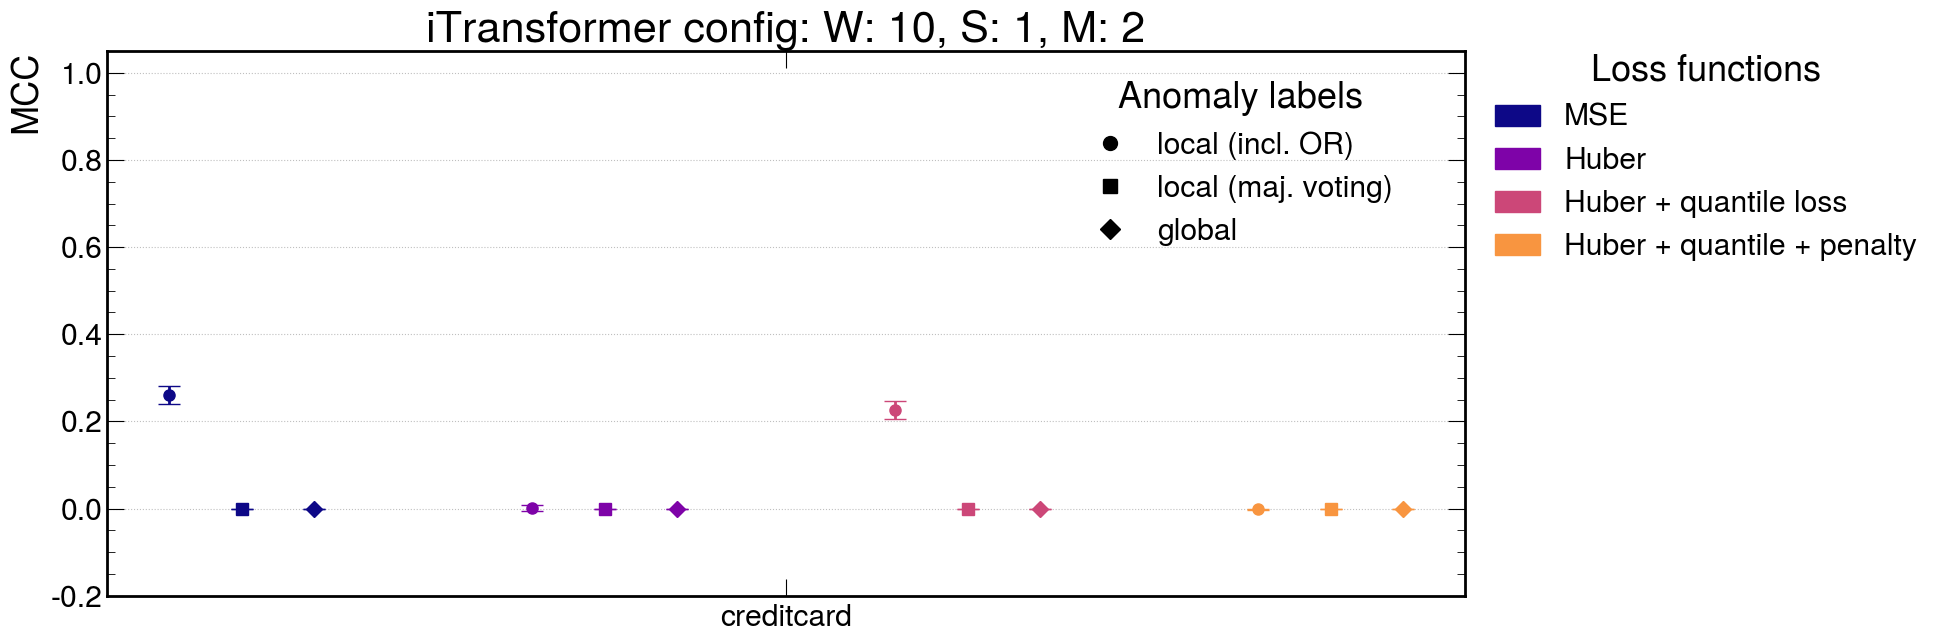

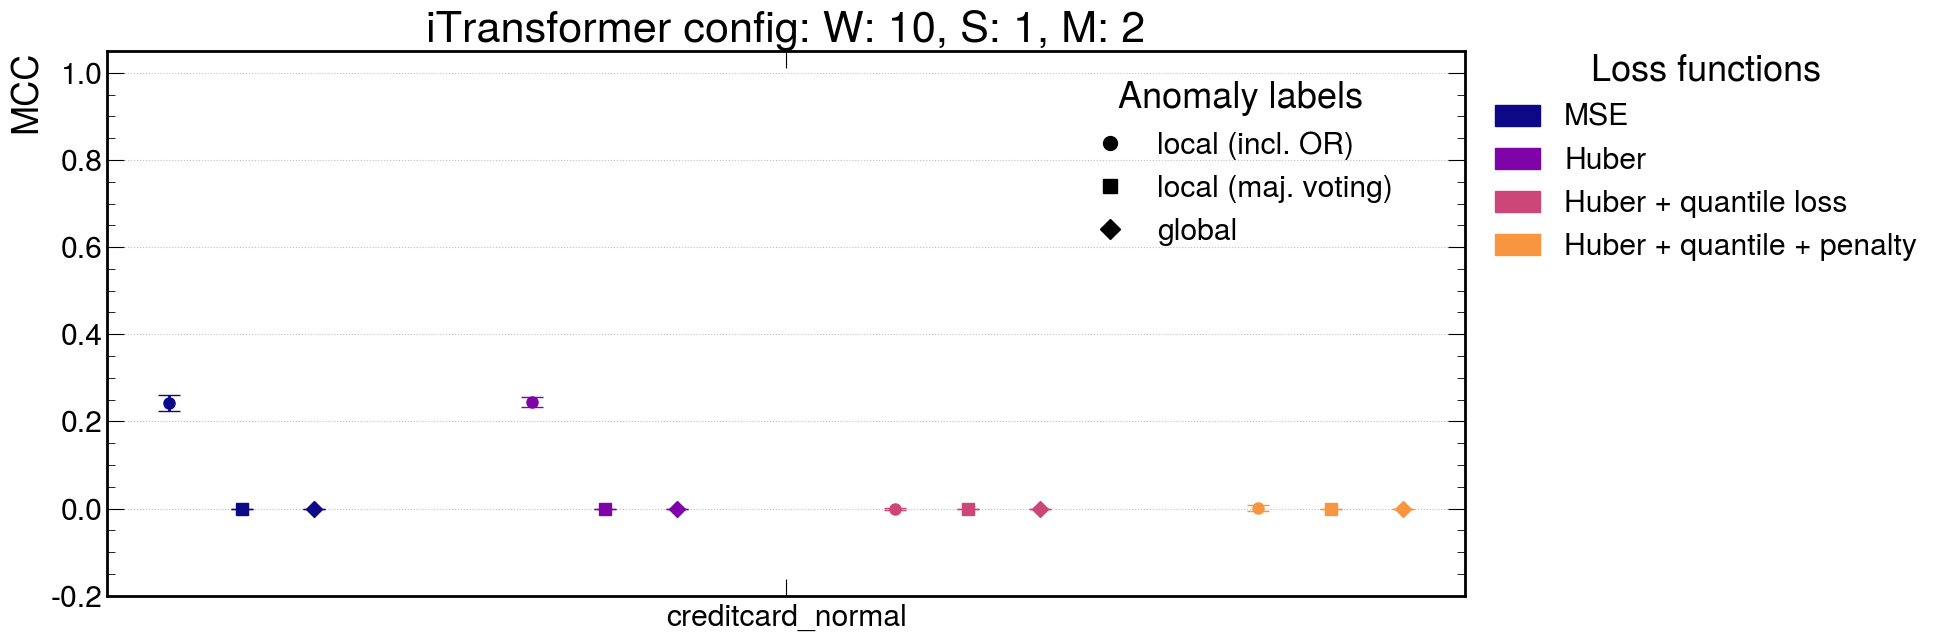

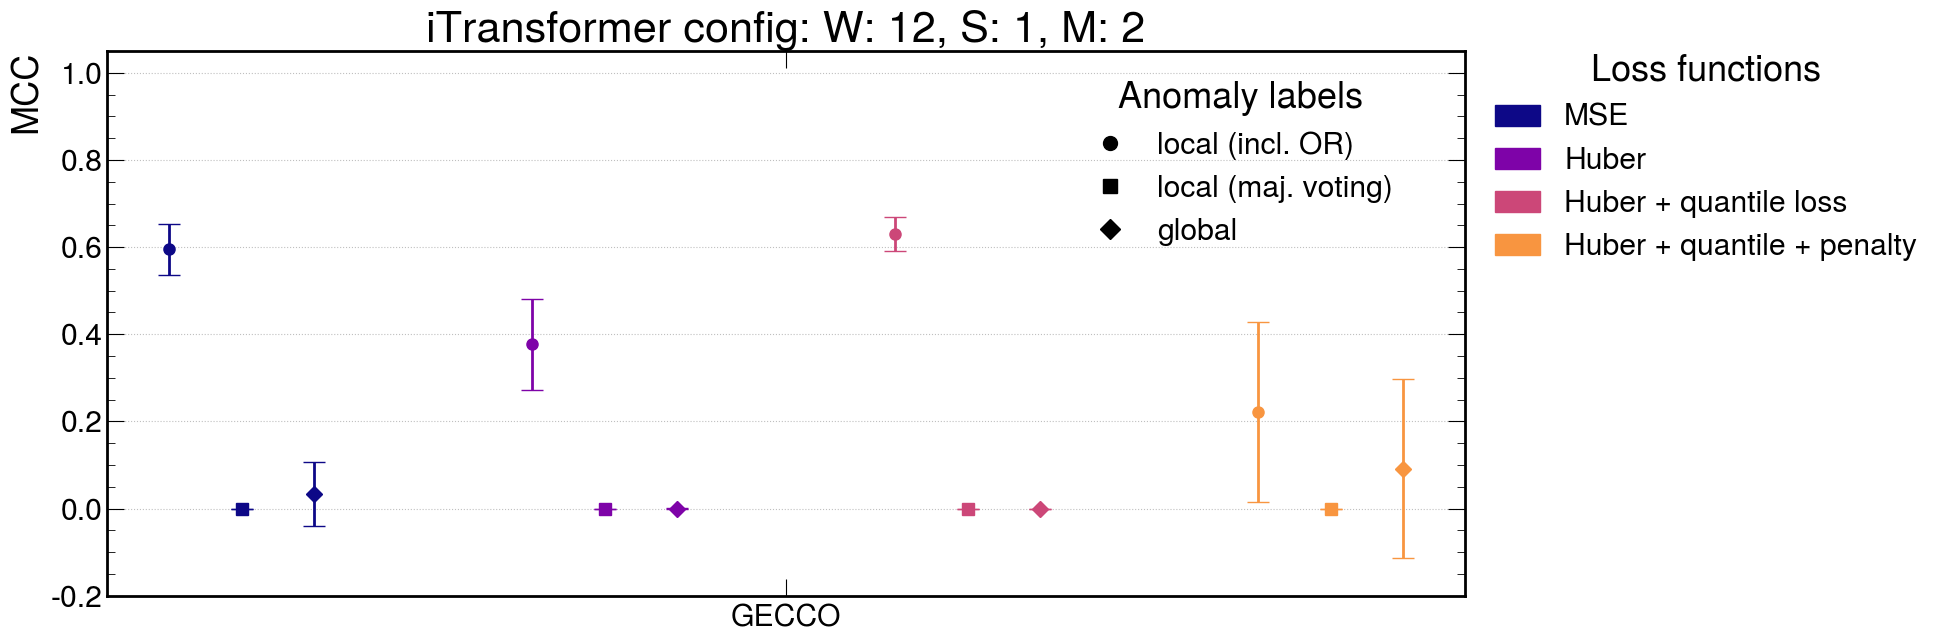

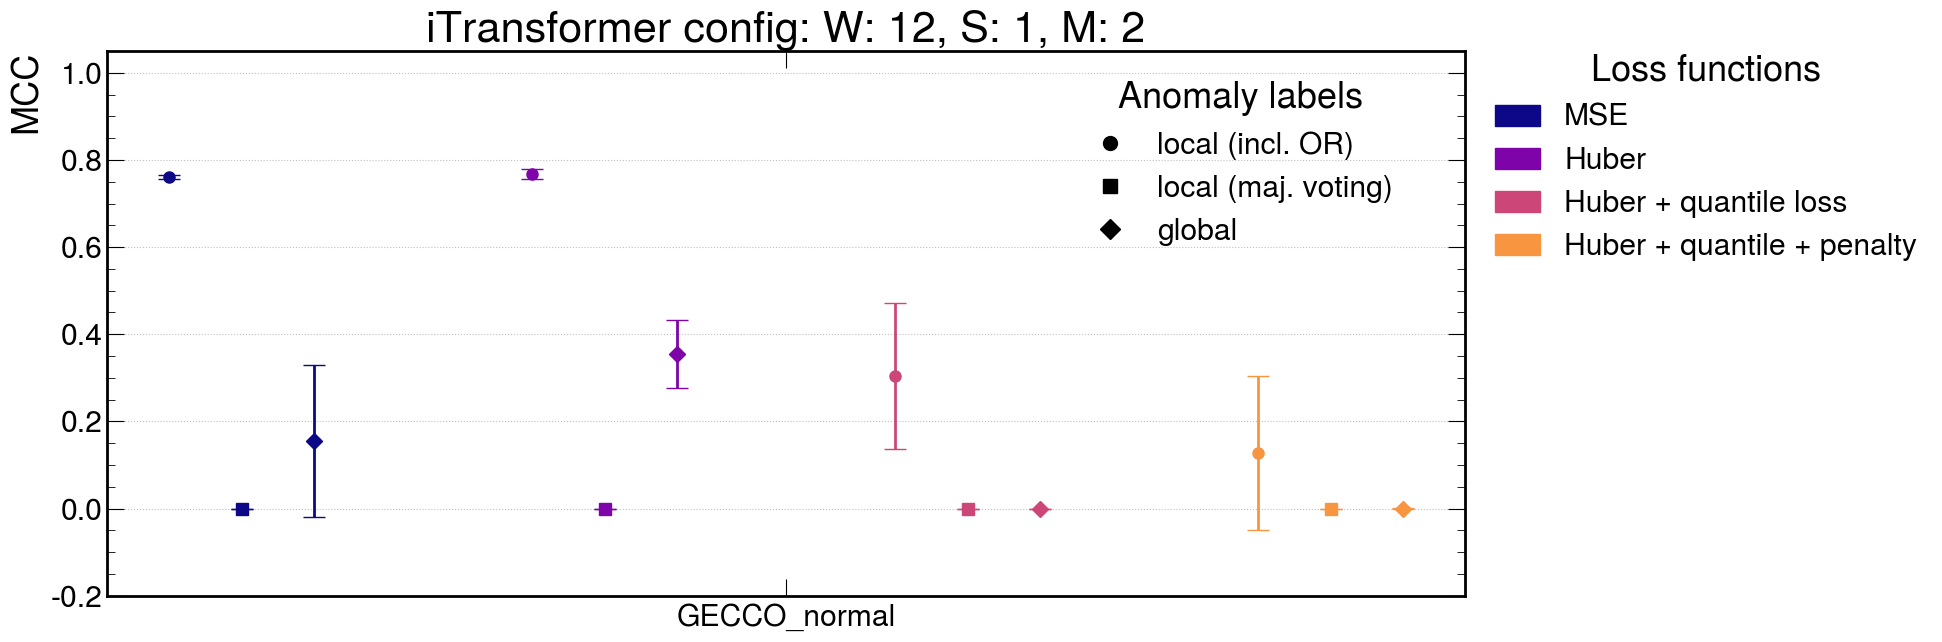

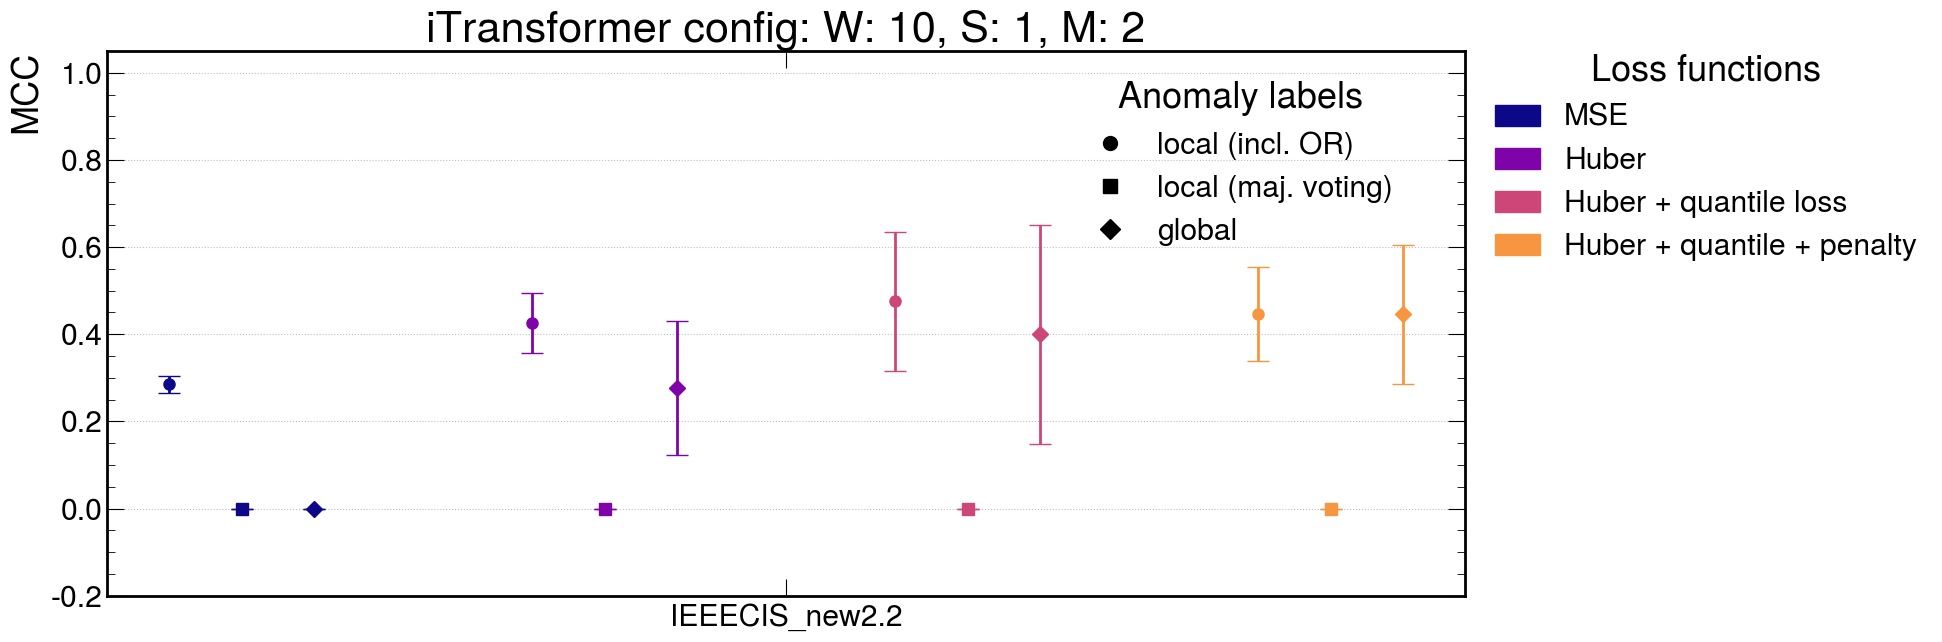

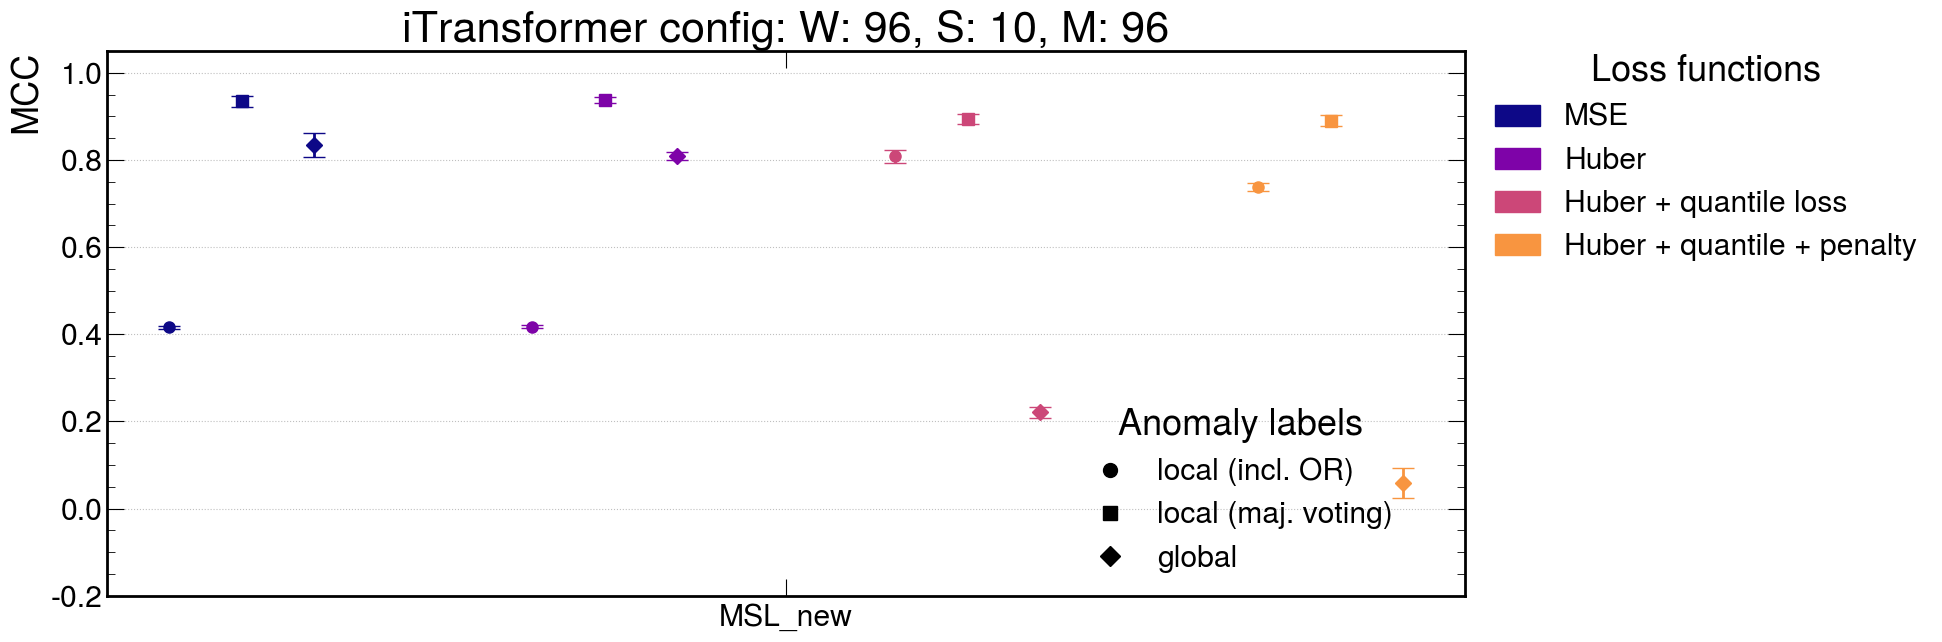

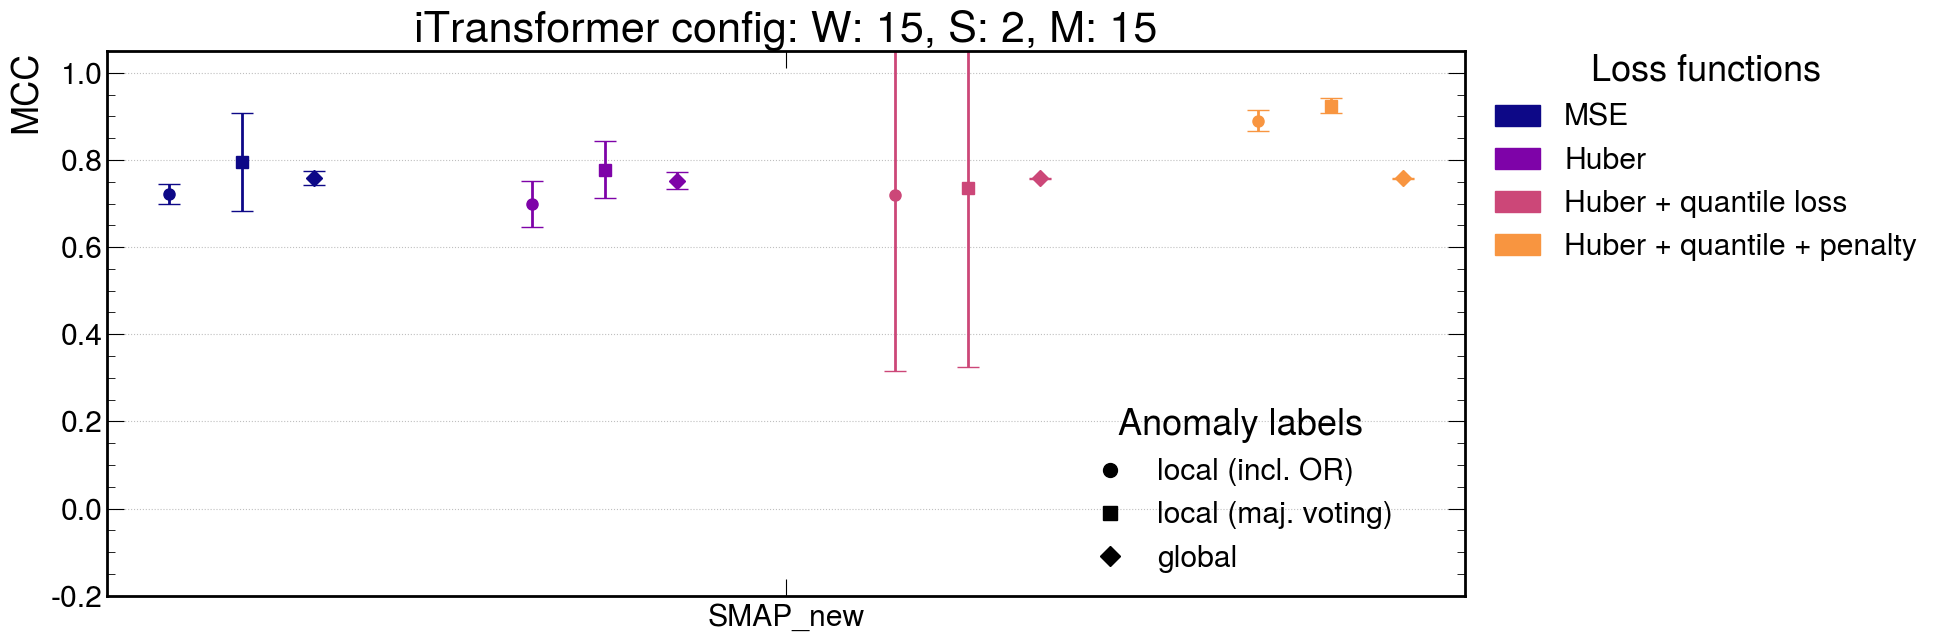

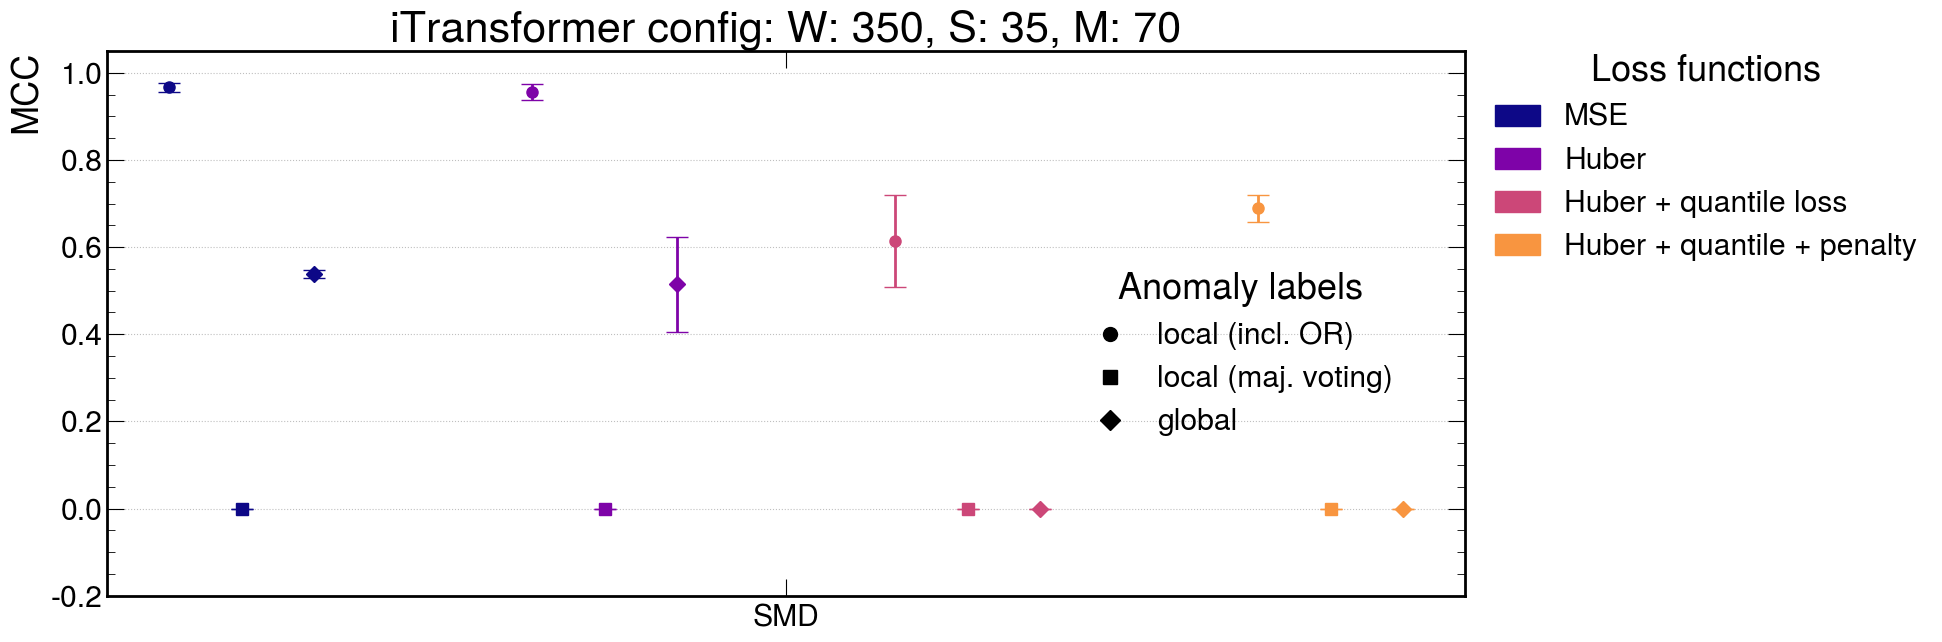

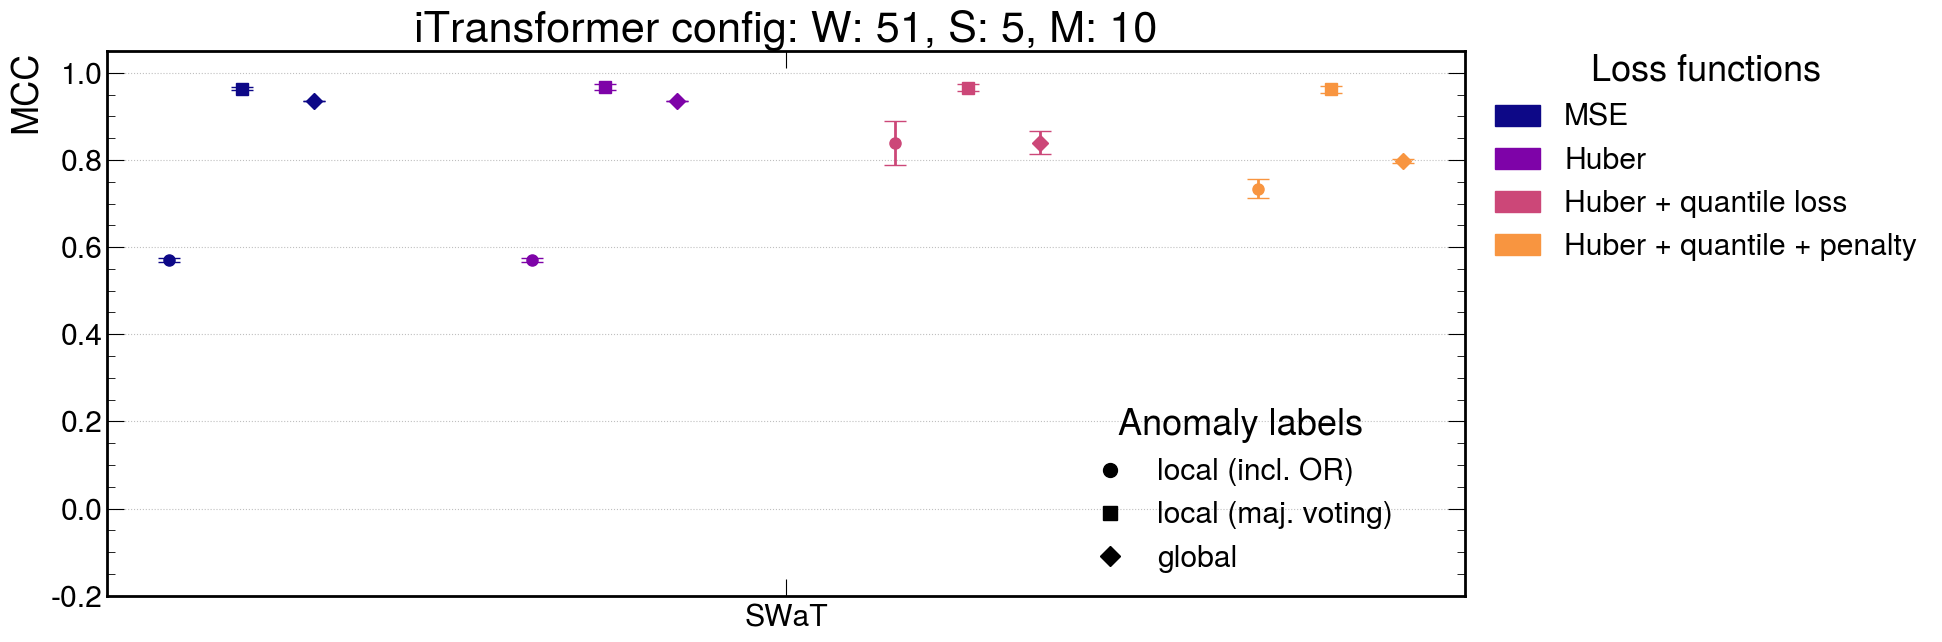

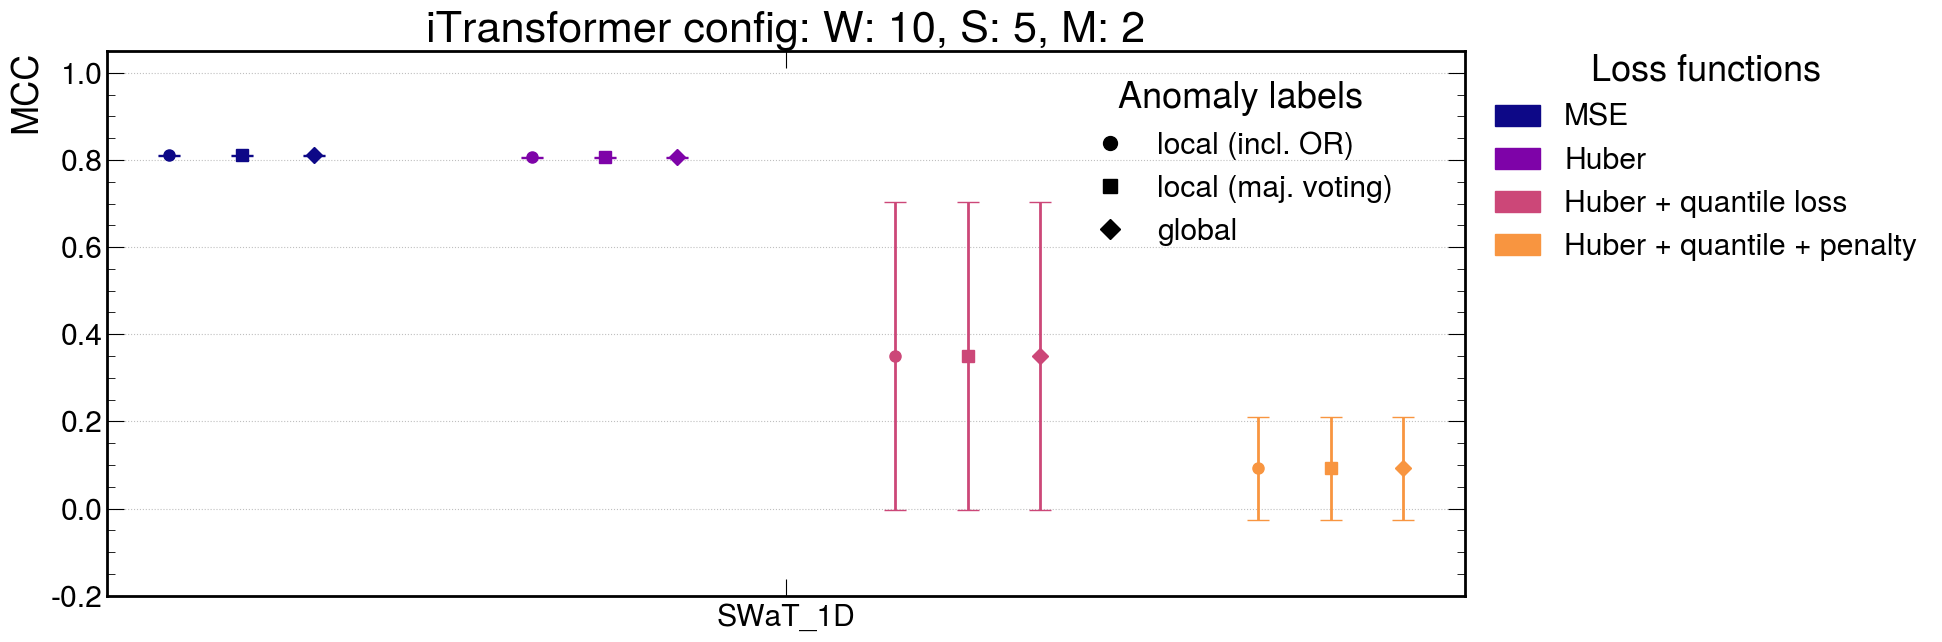

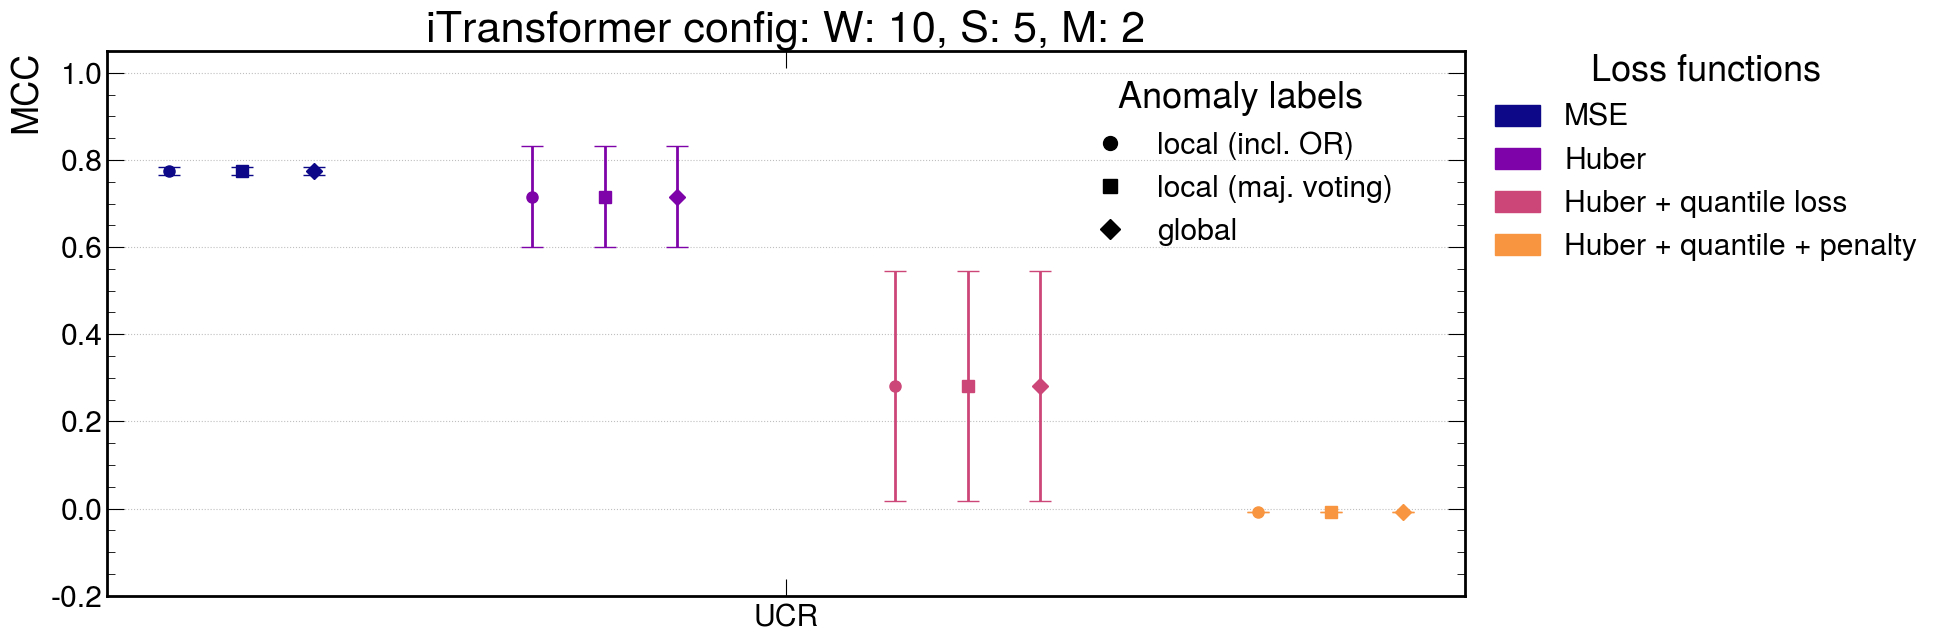

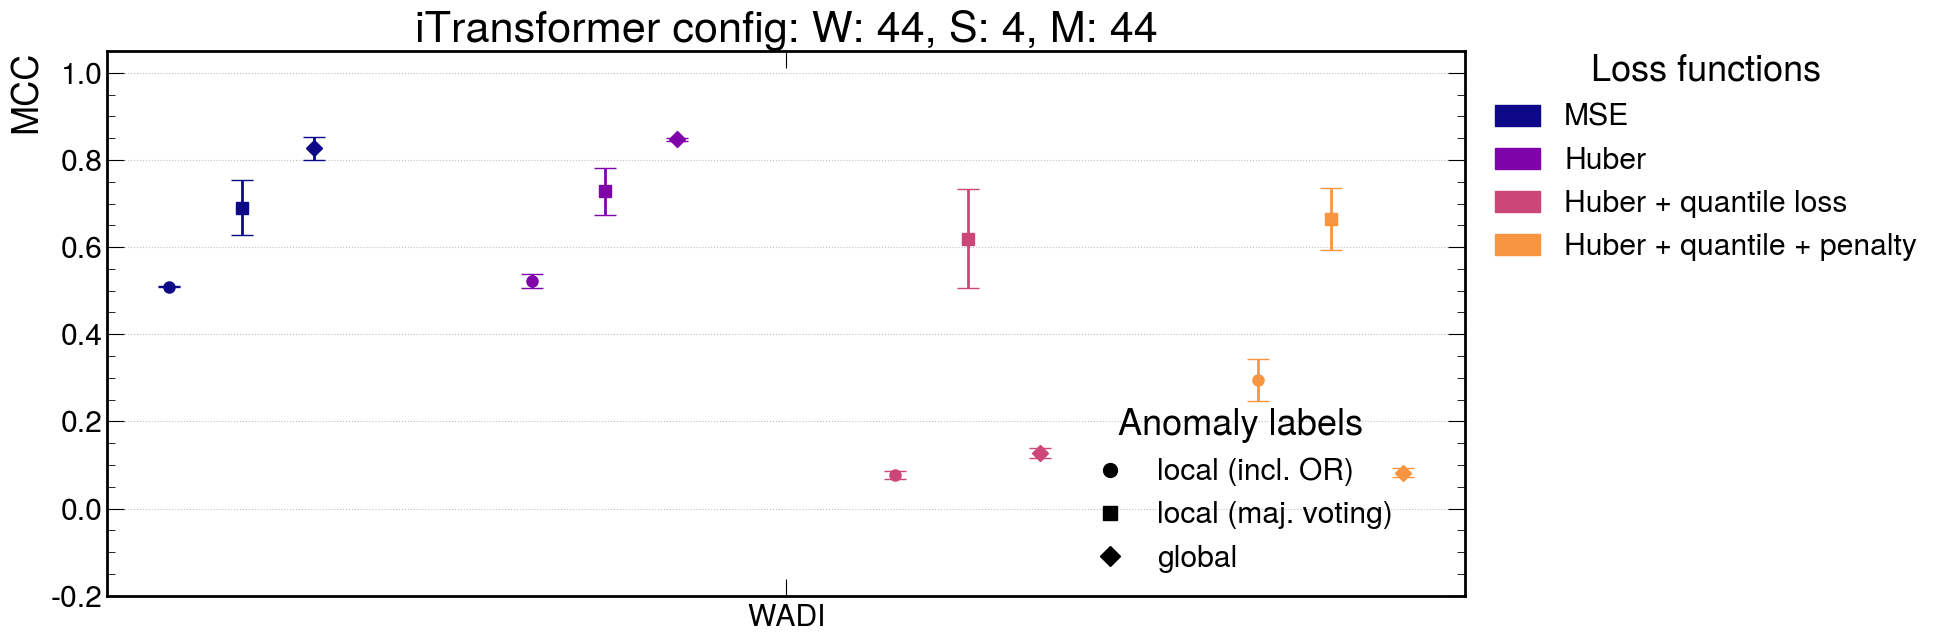

In [13]:
data_plot = datasets

for dataset in data_plot:
    models_plot = list(all_results[dataset].keys())
    labels = ['MSE', 'Huber', 'Huber + quantile loss', 'Huber + quantile + penalty']
    name = None
    plot_scores_mean_std_err2(all_results, modes, dataset, models_plot, metric='MCC', name=name, labels=labels)


In [ ]:
all_mcc_scores = []  # List to store all MCC scores across datasets

for dataset, results in all_results.items():
    if results == {}:
        print(f'Skipping {dataset} as it has no results')
        continue
    for key, metrics in results.items():
        all_mcc_scores.append({
            'dataset': dataset,
            'model': key,
            'local_all': metrics['mean'].loc['local_all', 'MCC'],
            'local_all_maj': metrics['mean'].loc['local_all_maj', 'MCC'],
            'global': metrics['mean'].loc['global', 'MCC'],
            'max_MCC': metrics['mean']['MCC'].max().round(3),
            'max_MCC_mode': metrics['mean']['MCC'].idxmax(),
            'local_all_std': rf"{metrics['mean'].loc['local_all', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['local_all', 'MCC'].round(3)}",
            'local_all_maj_std': rf"{metrics['mean'].loc['local_all_maj', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['local_all_maj', 'MCC'].round(3)}",
            'global_std': rf"{metrics['mean'].loc['global', 'MCC'].round(3)} $\pm$ {metrics['std'].loc['global', 'MCC'].round(3)}",
            'window': metrics['window'],
            'steps': metrics['steps'],
            'dmodel': metrics['dmodel'],
        })

# Create a single DataFrame from the collected data
all_mcc_df = pd.DataFrame(all_mcc_scores)
print(all_mcc_df)

# if reco:
#     all_mcc_df.to_csv(f'studies_loss_reco/all_datasets_mcc.csv')
# else:
#     all_mcc_df.to_csv(f'studies_loss_fc/all_datasets_mcc.csv')

In [ ]:
import torch.nn.functional as F 

In [ ]:
# # Define the range of x values
# x = torch.linspace(-4, 4, 100)

# # Compute activation function values
# y_relu = F.relu(x)
# y_leaky_relu = F.leaky_relu(x, negative_slope=0.1)
# y_sigmoid = torch.sigmoid(x)
# y_tanh = torch.tanh(x)
# y_elu = F.elu(x, alpha=1.0)
# y_softsign = F.softsign(x)
# # List of activation functions and their names
# activations = [
#     (y_relu, 'ReLU', r'$g(z) = $max$(0, z)$'),
#     (y_leaky_relu, 'Leaky ReLU', r'$g(z) = $ max$(0.1z, z)$'),
#     (y_sigmoid, 'Sigmoid', r'$g(z) = 1/(1+e^{-z})$'),
#     (y_tanh, 'Tanh', r'$g(z) = $tanh$(z)$'),
#     (y_elu, 'ELU', r'$g(z) = z$ if $z>0$'f'\n'r'$g(z)=e^z-1$ elsewhere'),
#     (y_softsign, 'Softsign', r'$g(z) = z/(1+|z|)$')
# ]
# # Create subplots
# fig, axes = plt.subplots(2, 3, figsize=(16, 10), sharex=True, sharey=True)
# axes = axes.ravel()

# colors = plt.cm.plasma(np.linspace(0, 1, len(activations)+1))

# for i, (y, name, equation) in enumerate(activations):
#     axes[i].plot(x.numpy(), y.numpy(), label=fr'{equation}', color=colors[i])
#     axes[i].axhline(0, color='black', linewidth=0.5, linestyle='--')
#     axes[i].axvline(0, color='black', linewidth=0.5, linestyle='--')
#     axes[i].legend(loc='upper left')
#     axes[i].grid()
#     axes[i].set_title(name)
# fig.supxlabel(r"$z$")
# fig.supylabel(r"Activation function $g(z)$")

# plt.tight_layout()
# plt.show()
